In [47]:
import pandas as pd
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error
from sklearn.metrics import f1_score
import seaborn

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

In [2]:
df = pd.read_csv('Cancer_Data.csv')
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [3]:
df.drop(columns='Unnamed: 32', inplace=True)

In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

/tmp/ipykernel_4597/4140933882.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr())


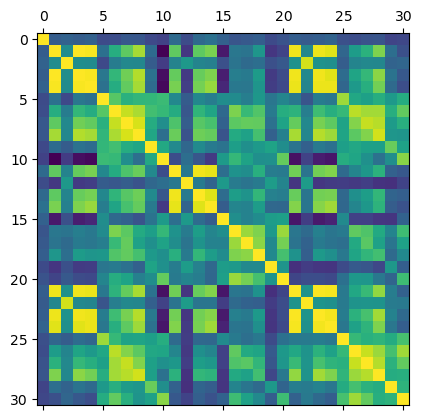

In [5]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
plt.show()

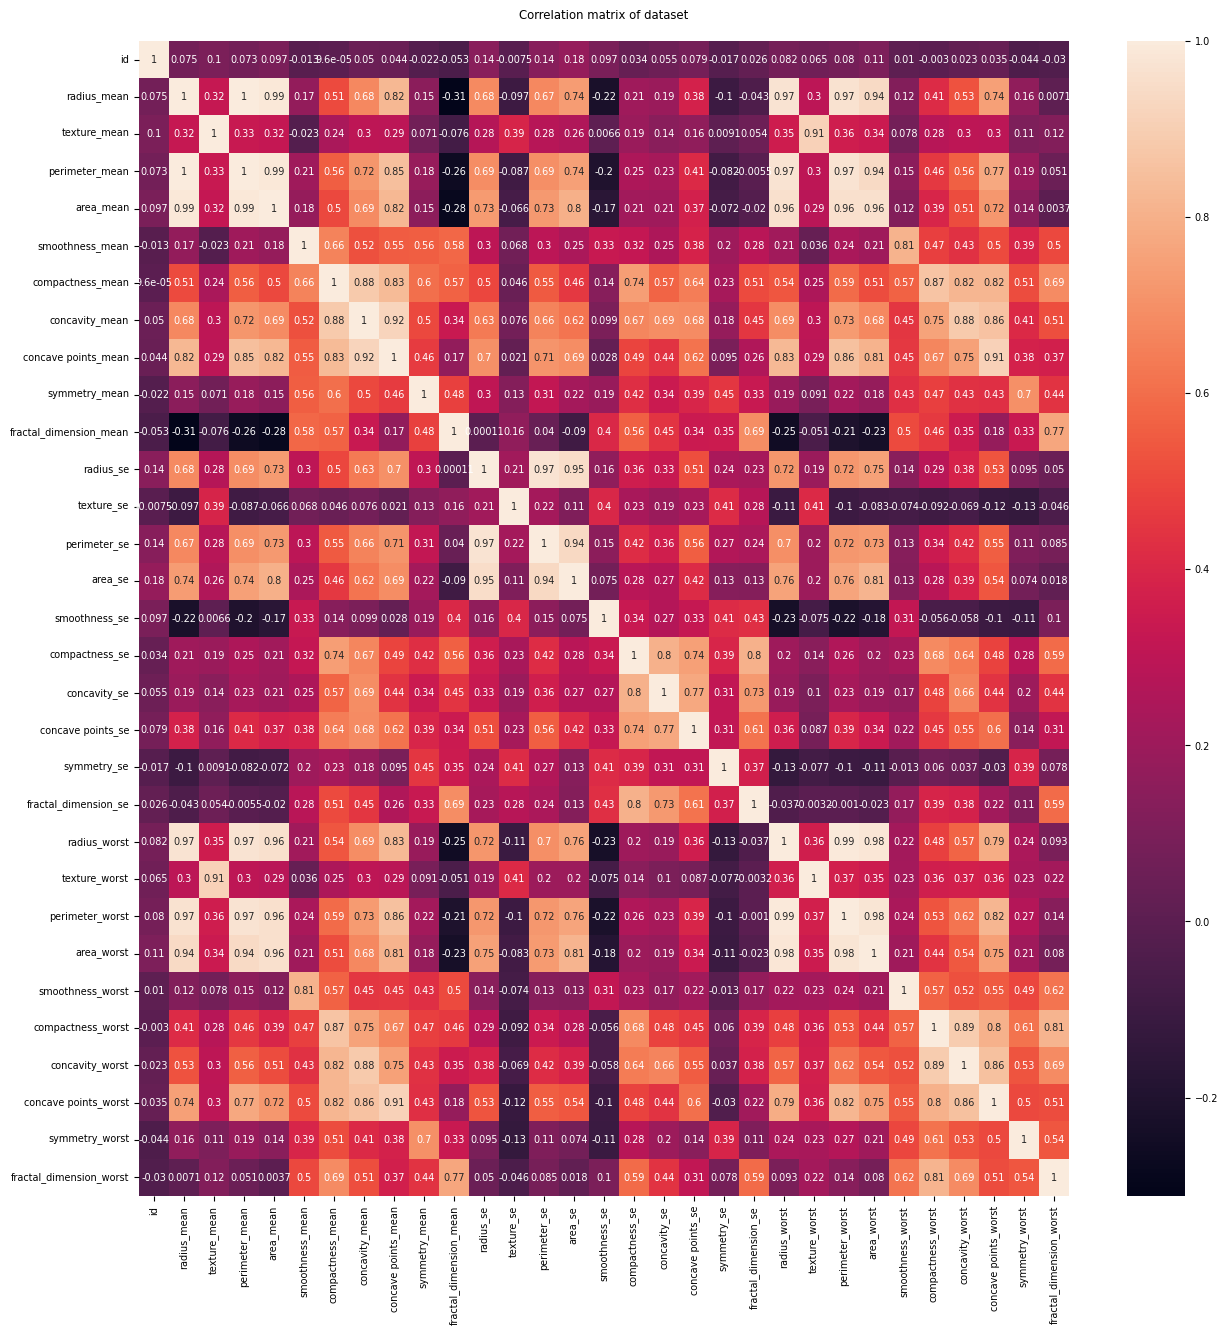

In [32]:
fig = plt.figure(figsize=((15, 15)))
correlation = df.corr()
heatmap = seaborn.heatmap(correlation, annot = True)
heatmap.set(title = "Correlation matrix of dataset\n")  
plt.show()

In [7]:
fig = plt.figure(figsize=(15, 15))
fig 

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [8]:
len(np.unique(df['id'])) == df.shape[0]

True

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [10]:
target = df['diagnosis']

In [11]:
target = target.map({'M': 1, "B": 0})

In [12]:
df.drop(columns='diagnosis', inplace=True)

In [22]:
plt.rcParams.update({'font.size': 7})

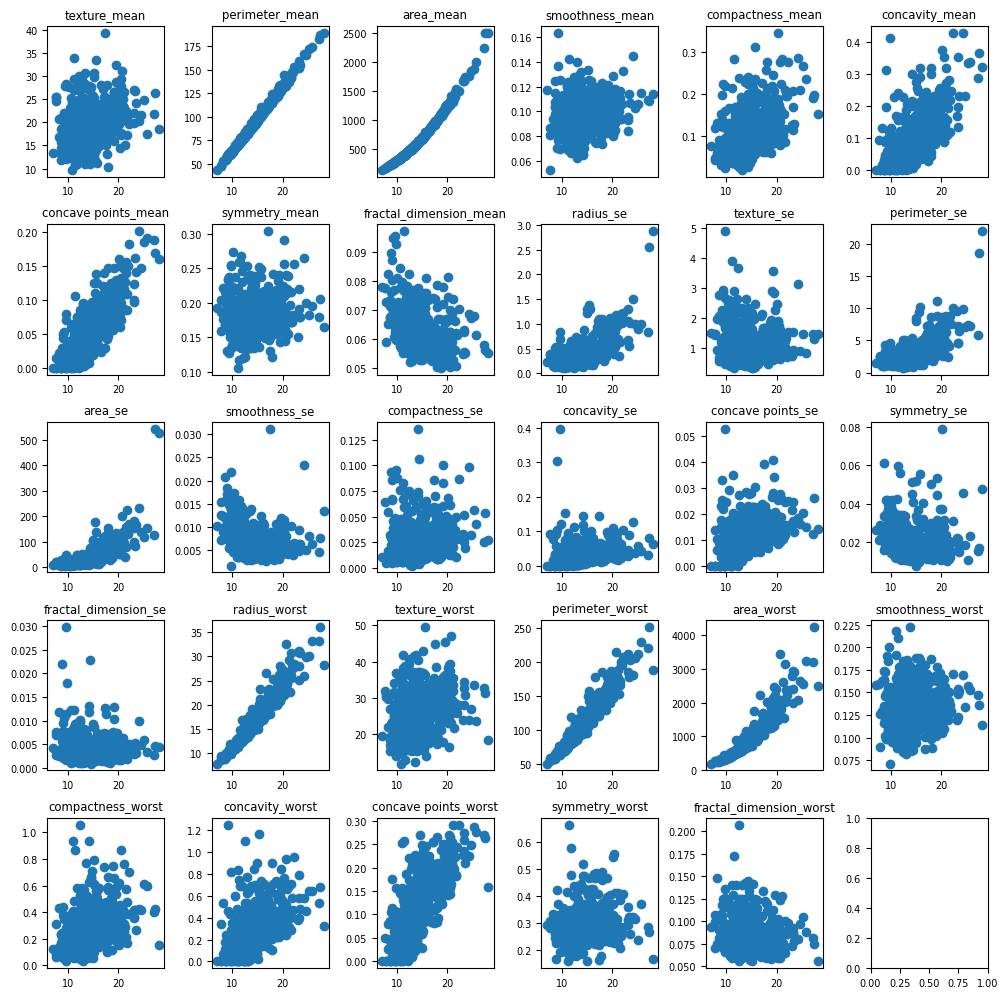

In [27]:
fig, _ = plt.subplots(5, 6)
axes = fig.get_axes()
fig.set_size_inches((10,10))
columns = df.drop(columns=['id', 'radius_mean']).columns
for i, feature in enumerate(columns):    
    axes[i].scatter(df['radius_mean'], df[feature])
    axes[i].set_title(feature)   
fig.tight_layout()

In [28]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 722.4 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 266.5 kB/s eta 0:00:00m eta 0:00:010:00:02
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.


In [29]:
import lightgbm as lgb

In [34]:
df['radius_mean/perimeter_mean'] = df['radius_mean']/df['perimeter_mean']
df['radius_mean/perimeter_worst'] = df['radius_mean']/df['perimeter_worst']
df['radius_mean/area_worst'] = df['radius_mean']/df['area_worst']
df['radius_mean/area_mean'] = df['radius_mean']/df['area_mean']
df['radius_mean/radius_worst'] = df['radius_mean']/df['radius_worst']
df.drop(columns=['perimeter_mean', 'perimeter_worst', 'area_worst', 'area_mean', 'radius_worst'], inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           569 non-null    int64  
 1   radius_mean                  569 non-null    float64
 2   texture_mean                 569 non-null    float64
 3   smoothness_mean              569 non-null    float64
 4   compactness_mean             569 non-null    float64
 5   concavity_mean               569 non-null    float64
 6   concave points_mean          569 non-null    float64
 7   symmetry_mean                569 non-null    float64
 8   fractal_dimension_mean       569 non-null    float64
 9   radius_se                    569 non-null    float64
 10  texture_se                   569 non-null    float64
 11  perimeter_se                 569 non-null    float64
 12  area_se                      569 non-null    float64
 13  smoothness_se       

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id']),target, test_size=0.3, random_state=42)

In [50]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.5041065864227174, F-Score=0.952, Precision=0.952, Recall=0.952


In [54]:
from sklearn.svm import SVC

In [63]:
clf = SVC(probability=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id']),target, test_size=0.3, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

In [64]:
y_pred

array([0.25038467, 0.99616925, 0.88066837, 0.04682347, 0.05600264,
       0.99999338, 0.98533052, 0.95314825, 0.04436377, 0.04436636,
       0.16917573, 0.98761047, 0.08310981, 0.96177802, 0.02350783,
       0.9945012 , 0.0601591 , 0.04172333, 0.01560181, 0.99623037,
       0.09638448, 0.11345014, 0.99697554, 0.04742535, 0.1214946 ,
       0.12612092, 0.03296912, 0.10363981, 0.07377794, 0.99547292,
       0.08203037, 0.02789612, 0.58532953, 0.05036372, 0.03705711,
       0.08921303, 0.86555237, 0.3008391 , 0.96192504, 0.5341387 ,
       0.08383245, 0.99029162, 0.03495878, 0.06134519, 0.69328424,
       0.08115338, 0.03480925, 0.37536679, 0.07404789, 0.07747375,
       0.89795201, 0.99665485, 0.08322361, 0.5       , 0.06509513,
       0.06161028, 0.06228389, 0.99329919, 0.09008578, 0.02162618,
       0.09151976, 0.99613378, 0.95992992, 0.20180863, 0.06198881,
       0.13580386, 0.98036975, 0.99370069, 0.05763058, 0.0724137 ,
       0.94992008, 0.95092357, 0.05432405, 0.48874815, 0.09060

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.47930460835265376, F-Score=0.906, Precision=0.892, Recall=0.921
